# Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import itertools

#LSTM modeling libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Dropout

Using TensorFlow backend.


In [3]:
yearly_df = pd.read_csv('Datasets/yearly_merged.csv')
yearly_df.tail()

,year,acousticness,danceability,duration_ms,energy,loudness,instrumentalness,liveness,speechiness,tempo,valence,popularity,key
95,2016,0.1530,0.6130,215440.0,0.6180,-6.6090,0.000002,0.121,0.05760,119.9060,0.4090,61.0,0
96,2017,0.1720,0.6400,209132.0,0.6085,-6.8080,0.000002,0.125,0.06240,117.2825,0.4065,64.0,1
97,2018,0.1710,0.6870,199560.0,0.6030,-6.3720,0.000000,0.120,0.06975,121.1435,0.4390,66.0,1
98,2019,0.1785,0.6790,194044.0,0.6200,-6.3295,0.000000,0.118,0.06840,118.0425,0.4690,68.5,1
99,2020,0.1490,0.6925,193467.0,0.6265,-6.3330,0.000000,0.122,0.08310,121.9415,0.4850,68.0,1


In [4]:
yearly_df['year']

0     1921
1     1922
2     1923
3     1924
4     1925
      ... 
95    2016
96    2017
97    2018
98    2019
99    2020
Name: year, Length: 100, dtype: int64

Let's now convert our year column to datetime format and set it as the index.

In [5]:
yearly_df['year'] = pd.to_datetime(yearly_df['year'], format='%Y')
yearly_df.set_index('year', inplace=True) 
yearly_df.head()

,acousticness,danceability,duration_ms,energy,loudness,instrumentalness,liveness,speechiness,tempo,valence,popularity,key
year,,,,,,,,,,,,
1921-01-01,0.990,0.4115,178040.0,0.2205,-16.0000,0.0287,0.1655,0.04595,92.1440,0.4545,0.0,7
1922-01-01,0.994,0.4895,168053.5,0.2010,-18.6210,0.3245,0.1575,0.06665,89.6905,0.5490,0.0,10
1923-01-01,0.992,0.5765,180347.0,0.2465,-13.9605,0.2180,0.1725,0.06775,108.3805,0.6115,4.0,0
1924-01-01,0.994,0.5650,173786.5,0.3250,-13.8420,0.8440,0.1855,0.06550,118.3225,0.6995,0.0,10
1925-01-01,0.989,0.5750,179360.0,0.2390,-13.5520,0.1740,0.1550,0.07560,114.0380,0.6590,0.0,5


In [6]:

yearly_df

,acousticness,danceability,duration_ms,energy,loudness,instrumentalness,liveness,speechiness,tempo,valence,popularity,key
year,,,,,,,,,,,,
1921-01-01,0.9900,0.4115,178040.0,0.2205,-16.0000,0.028700,0.1655,0.04595,92.1440,0.4545,0.0,7
1922-01-01,0.9940,0.4895,168053.5,0.2010,-18.6210,0.324500,0.1575,0.06665,89.6905,0.5490,0.0,10
1923-01-01,0.9920,0.5765,180347.0,0.2465,-13.9605,0.218000,0.1725,0.06775,108.3805,0.6115,4.0,0
1924-01-01,0.9940,0.5650,173786.5,0.3250,-13.8420,0.844000,0.1855,0.06550,118.3225,0.6995,0.0,10
1925-01-01,0.9890,0.5750,179360.0,0.2390,-13.5520,0.174000,0.1550,0.07560,114.0380,0.6590,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-01,0.1530,0.6130,215440.0,0.6180,-6.6090,0.000002,0.1210,0.05760,119.9060,0.4090,61.0,0
2017-01-01,0.1720,0.6400,209132.0,0.6085,-6.8080,0.000002,0.1250,0.06240,117.2825,0.4065,64.0,1
2018-01-01,0.1710,0.6870,199560.0,0.6030,-6.3720,0.000000,0.1200,0.06975,121.1435,0.4390,66.0,1


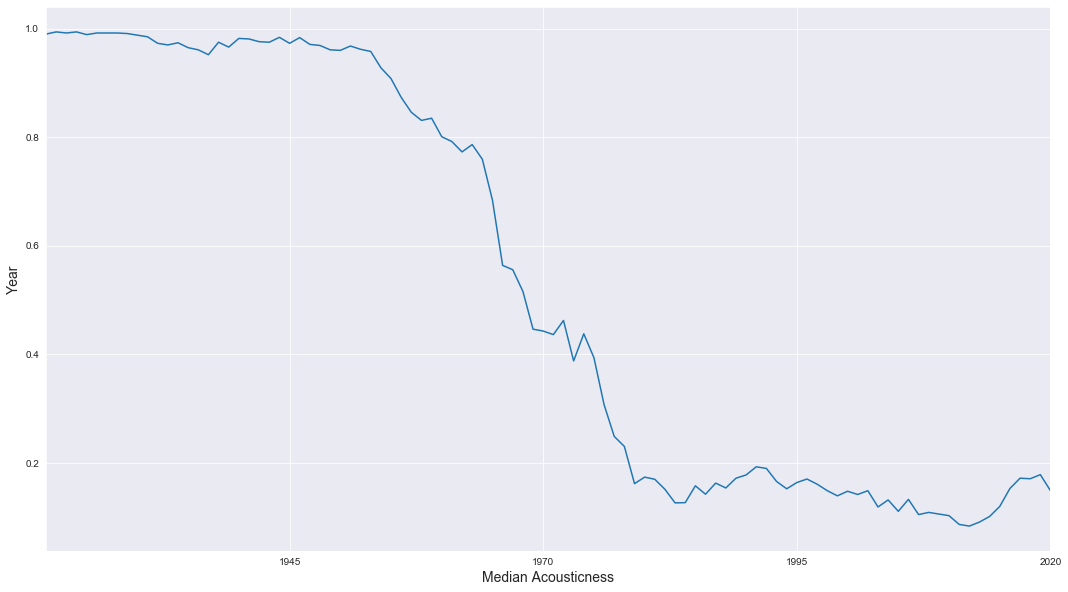

In [7]:
yearly_df.acousticness.plot(figsize = (18,10))
plt.xlabel('Median Acousticness', fontsize=14)
plt.ylabel('Year', fontsize=14)
plt.savefig('Images/acousticness_time.png');

Let's take a look at the rolling mean and standard deviation of acousticness, using a window of 6 steps (6 years).

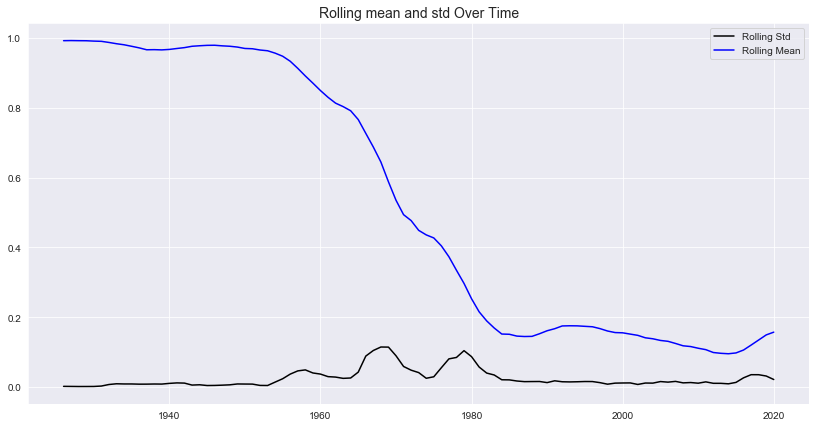

In [8]:
roll_mean = yearly_df.acousticness.rolling(window=6, center=False).mean()
roll_std = yearly_df.acousticness.rolling(window=6, center=False).std()

fig = plt.figure(figsize=(14,7))
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.plot(roll_mean, color='blue', label = 'Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling mean and std Over Time', size=14)
plt.show(block=False)

The rolling average is as expected, with total acousticness in heavy decline during 60's, 70's and 80's. The standard deviation shows greater volatility during this time.

Let's now decompose acousticness just to see what the residuals are like.

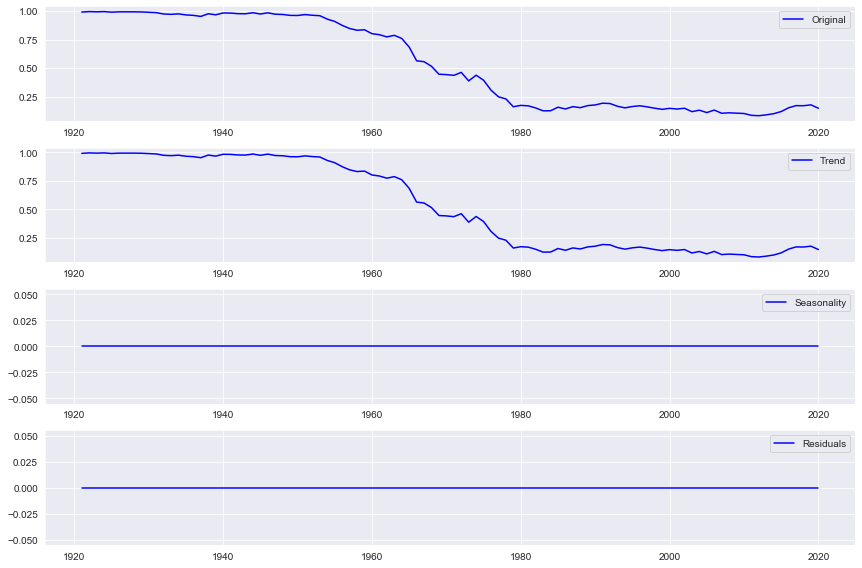

In [9]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(yearly_df.acousticness)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(yearly_df.acousticness, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('Images/Acousticness_decomposition.png')

Residuals are completely absent. This could be due to the fact that we only have yearly data points.

Let's now make our trend stationary and get plots for the ACF and PACF. 

In [9]:
yearly_df.acousticness

year
1921-01-01    0.9900
1922-01-01    0.9940
1923-01-01    0.9920
1924-01-01    0.9940
1925-01-01    0.9890
               ...  
2016-01-01    0.1530
2017-01-01    0.1720
2018-01-01    0.1710
2019-01-01    0.1785
2020-01-01    0.1490
Name: acousticness, Length: 100, dtype: float64

In [10]:
data_diff = yearly_df.acousticness.diff().dropna() #1-lag differencing, notice the start year
data_diff

year
1922-01-01    0.0040
1923-01-01   -0.0020
1924-01-01    0.0020
1925-01-01   -0.0050
1926-01-01    0.0030
               ...  
2016-01-01    0.0330
2017-01-01    0.0190
2018-01-01   -0.0010
2019-01-01    0.0075
2020-01-01   -0.0295
Name: acousticness, Length: 99, dtype: float64

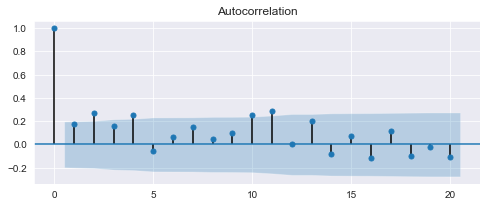

In [11]:
# Plot the ACF, shows us how many MA terms are required to remove any autocorrelation in the stationarized series.
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(data_diff,ax=ax, lags=20)
plt.savefig('Images/ACF_acousticness.png');

MA seems to be 1.

we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot

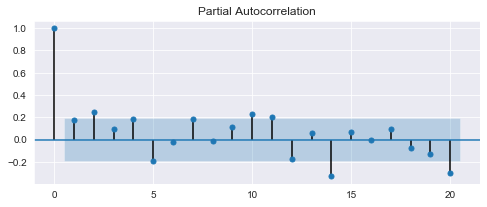

In [12]:
# Plot the PACF
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(data_diff,ax=ax, lags=20)
plt.savefig('Images/PACF_acousticness.png');

AR for our differenced data seems to be 1.

# Baseline Model (ARIMA)
As there is no seaonality because our data is yearly, we will leave out the seasonality portion of the SARIMA model.

In [13]:
# Let's set the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)


# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [14]:
ans = []
for comb in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(yearly_df.acousticness,
                                        order=comb,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
    except:
        continue

ARIMA (0, 0, 0) : AIC Calculated =197.8299228950407
ARIMA (0, 0, 1) : AIC Calculated =68.29260070893079
ARIMA (0, 0, 2) : AIC Calculated =-42.65550451839651
ARIMA (0, 1, 0) : AIC Calculated =-427.05966527244937
ARIMA (0, 1, 1) : AIC Calculated =-423.8660853219406
ARIMA (0, 1, 2) : AIC Calculated =-421.9185352745262
ARIMA (0, 2, 0) : AIC Calculated =-383.9978379490176
ARIMA (0, 2, 1) : AIC Calculated =-431.00915595075935
ARIMA (0, 2, 2) : AIC Calculated =-423.64127707525313
ARIMA (1, 0, 0) : AIC Calculated =-439.3140562327019
ARIMA (1, 0, 1) : AIC Calculated =-434.7111062963007
ARIMA (1, 0, 2) : AIC Calculated =-431.5385633725217
ARIMA (1, 1, 0) : AIC Calculated =-431.80674441164655
ARIMA (1, 1, 1) : AIC Calculated =-436.2438081655385
ARIMA (1, 1, 2) : AIC Calculated =-429.0003291537753
ARIMA (1, 2, 0) : AIC Calculated =-417.55815675252103
ARIMA (1, 2, 1) : AIC Calculated =-428.93936785393464
ARIMA (1, 2, 2) : AIC Calculated =-423.03557644736225
ARIMA (2, 0, 0) : AIC Calculated =-436.11

In [15]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq    (2, 0, 1)
aic     -442.685
Name: 19, dtype: object

In [16]:
#Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(yearly_df.acousticness, 
                                        order=(2, 0, 1),  
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9216      0.057     33.846      0.000       1.810       2.033
ar.L2         -0.9232      0.055    -16.642      0.000      -1.032      -0.814
ma.L1         -1.2214      0.143     -8.546      0.000      -1.502      -0.941
sigma2         0.0004      0.000      3.675      0.000       0.000       0.001


P-values in check on first try! Very good.

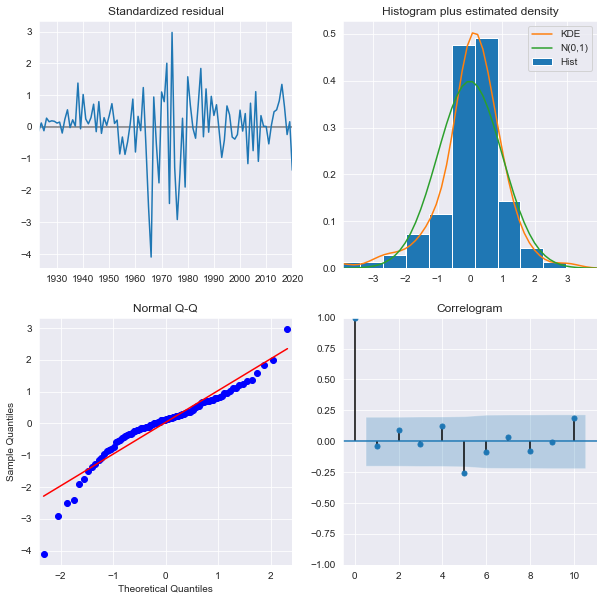

In [17]:
output.plot_diagnostics(figsize=(10, 10))
plt.show()

Our summary plots show that we have a little ways to go in order for our data's KDE curve to fit that of a normal distribution. Same shape, but a little condensed in the middle. Let's see what our RMSE is for this model.

In [18]:
pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

# Get the real and predicted values
acousticness_forecasted = pred.predicted_mean             #series
acousticness_truth = yearly_df.acousticness['2015-01-01':].T.squeeze()  #slicing the list and squeezing to a series also

# Compute the root mean square error
rmse = np.sqrt(((acousticness_forecasted - acousticness_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 5)))

The Root Mean Squared Error of our forecasts is 0.02161


0.02 is not too bad. Let's see if we can alter the RMSE by sliding the test set backwards to 2010 (for our model's validation).

In [19]:
pred = output.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
pred_conf = pred.conf_int()

# Get the real and predicted values
acousticness_forecasted = pred.predicted_mean             #series
acousticness_truth = yearly_df.acousticness['2010-01-01':].T.squeeze()  #slicing the list and squeezing to a series also

# Compute the root mean square error
rmse = np.sqrt(((acousticness_forecasted - acousticness_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 5)))

The Root Mean Squared Error of our forecasts is 0.01725


Decent reduction in RMSE for testing on less of the data.

## Log values

Let's try the taking the logarithm of our data and running the model again using the same parameter range.

In [20]:
log_acousticness = np.log(yearly_df.acousticness)

In [21]:
# Let's set the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [22]:
ans = []
for comb in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(log_acousticness,
                                        order=comb,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
    except:
        continue

ARIMA (0, 0, 0) : AIC Calculated =339.9627555807098
ARIMA (0, 0, 1) : AIC Calculated =217.8338879833271
ARIMA (0, 0, 2) : AIC Calculated =120.47555185855174
ARIMA (0, 1, 0) : AIC Calculated =-173.8695310047128
ARIMA (0, 1, 1) : AIC Calculated =-169.18456732468243
ARIMA (0, 1, 2) : AIC Calculated =-172.26634549739535
ARIMA (0, 2, 0) : AIC Calculated =-109.72166331702994
ARIMA (0, 2, 1) : AIC Calculated =-167.5699052886636
ARIMA (0, 2, 2) : AIC Calculated =-163.1042229674745
ARIMA (1, 0, 0) : AIC Calculated =-175.74676302260968
ARIMA (1, 0, 1) : AIC Calculated =-170.980259189975
ARIMA (1, 0, 2) : AIC Calculated =-173.63488676670886
ARIMA (1, 1, 0) : AIC Calculated =-172.04586005476418
ARIMA (1, 1, 1) : AIC Calculated =-171.0143994944153
ARIMA (1, 1, 2) : AIC Calculated =-173.5882325961216
ARIMA (1, 2, 0) : AIC Calculated =-160.39250362828128
ARIMA (1, 2, 1) : AIC Calculated =-165.9266739331269
ARIMA (1, 2, 2) : AIC Calculated =-166.47415522032446
ARIMA (2, 0, 0) : AIC Calculated =-171.00

In [23]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq    (2, 1, 0)
aic     -178.565
Name: 21, dtype: object

In [24]:
#Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_acousticness, 
                                        order=(2, 1, 0),  
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0257      0.085      0.302      0.763      -0.141       0.193
ar.L2          0.3380      0.075      4.535      0.000       0.192       0.484
sigma2         0.0087      0.001      8.838      0.000       0.007       0.011


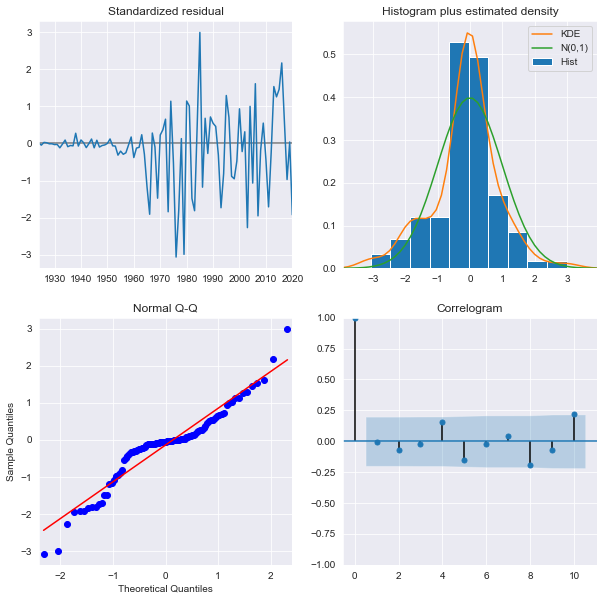

In [25]:
output.plot_diagnostics(figsize=(10, 10))
plt.show()

In [26]:
pred = output.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
pred_conf = pred.conf_int()

# Get the real and predicted values
acousticness_forecasted = np.exp(pred.predicted_mean )            #series
acousticness_truth = yearly_df.acousticness['2010-01-01':].T.squeeze()  #slicing the list and squeezing to a series also

# Compute the root mean square error
rmse = np.sqrt(((acousticness_forecasted - acousticness_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 5)))

The Root Mean Squared Error of our forecasts is 0.01581


RMSE is a bit lower here, despite our Q-Q residuals being a bit more off.

## differenced data

In [27]:
ans = []
for comb in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(data_diff,
                                        order=comb,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
    except:
        continue

ARIMA (0, 0, 0) : AIC Calculated =-427.0596603919106
ARIMA (0, 0, 1) : AIC Calculated =-423.84205111233234
ARIMA (0, 0, 2) : AIC Calculated =-421.86196228406675
ARIMA (0, 1, 0) : AIC Calculated =-383.9978379785258
ARIMA (0, 1, 1) : AIC Calculated =-430.7701239860368
ARIMA (0, 1, 2) : AIC Calculated =-423.3756353613856
ARIMA (0, 2, 0) : AIC Calculated =-270.79613470859897
ARIMA (0, 2, 1) : AIC Calculated =-368.6177726399038
ARIMA (0, 2, 2) : AIC Calculated =-411.7954220549195
ARIMA (1, 0, 0) : AIC Calculated =-431.8067444116465
ARIMA (1, 0, 1) : AIC Calculated =-435.7597977248665
ARIMA (1, 0, 2) : AIC Calculated =-428.46728524829285
ARIMA (1, 1, 0) : AIC Calculated =-417.55815633807293
ARIMA (1, 1, 1) : AIC Calculated =-428.9393685434568
ARIMA (1, 1, 2) : AIC Calculated =-422.74677678622845
ARIMA (1, 2, 0) : AIC Calculated =-337.9075310080594
ARIMA (1, 2, 1) : AIC Calculated =-401.0331218486727
ARIMA (1, 2, 2) : AIC Calculated =-410.1767632940044
ARIMA (2, 0, 0) : AIC Calculated =-433.1

In [28]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq    (1, 0, 1)
aic      -435.76
Name: 10, dtype: object

In [29]:
#Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(data_diff, 
                                        order=(1, 0, 1),  
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9469      0.038     24.728      0.000       0.872       1.022
ma.L1         -0.7971      0.083     -9.655      0.000      -0.959      -0.635
sigma2         0.0006   5.88e-05     10.364      0.000       0.000       0.001


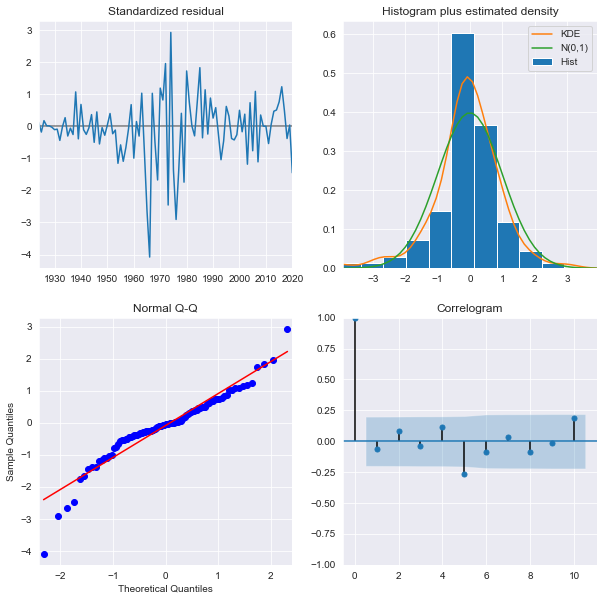

In [30]:
output.plot_diagnostics(figsize=(10, 10))
plt.show()

In [31]:
pred = output.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
pred_conf = pred.conf_int()

# Get the real and predicted values
acousticness_forecasted = pred.predicted_mean            #series
acousticness_truth = data_diff['2010-01-01':]  #slicing the list and squeezing to a series also

# Compute the root mean square error
rmse = np.sqrt(((acousticness_forecasted - acousticness_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 5)))

The Root Mean Squared Error of our forecasts is 0.01722


Differenced data seems to be doing well.
*Note it is not required to input differenced data into the ARIMA model, because it does the differencing for you.*

# LSTM Modeling

*split_sequence function and guidance obtained from https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ and others.

In [32]:
# Splitting our data into a training set and testing set

train=yearly_df.acousticness[:90] # 90/100 = 90% split 
test=yearly_df.acousticness[90:]

*Note:* We tried the train/test split at 80% and received worse results

### Prepping the time sequence for modeling
Here we will define a function that splits our data into a sequence of specified steps. This is because the (Long Short Term Memory) model will use a certain number of steps in the past for each future prediction.

In [43]:
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

Now we will split our acousticness sequence, with each output step having 3 input steps.

In [44]:
# define input sequence
train_seq = list(train)
test_seq = list(test)
raw_seq = yearly_df.acousticness

# choose a number of time steps
n_steps = 3      #5 steps and 2 steps received worse results

# split into samples
X, y = split_sequence(raw_seq, n_steps)
X_train, y_train = split_sequence(train_seq, n_steps)
X_test, y_test = split_sequence(test_seq, n_steps) 

n_features = 1

# #reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))


# print the data sequence with steps:
for i in range(len(X)):
	print(X_train[i], y_train[i])

[[ 0.004]
 [-0.002]
 [ 0.002]] -0.0050000000000000044
[[-0.002]
 [ 0.002]
 [-0.005]] 0.0030000000000000027
[[ 0.002]
 [-0.005]
 [ 0.003]] 0.0
[[-0.005]
 [ 0.003]
 [ 0.   ]] 0.0
[[0.003]
 [0.   ]
 [0.   ]] -0.0010000000000000009
[[ 0.   ]
 [ 0.   ]
 [-0.001]] -0.0030000000000000027
[[ 0.   ]
 [-0.001]
 [-0.003]] -0.0030000000000000027
[[-0.001]
 [-0.003]
 [-0.003]] -0.01200000000000001
[[-0.003]
 [-0.003]
 [-0.012]] -0.0030000000000000027
[[-0.003]
 [-0.012]
 [-0.003]] 0.0040000000000000036
[[-0.012]
 [-0.003]
 [ 0.004]] -0.009000000000000008
[[-0.003]
 [ 0.004]
 [-0.009]] -0.0040000000000000036
[[ 0.004]
 [-0.009]
 [-0.004]] -0.009000000000000008
[[-0.009]
 [-0.004]
 [-0.009]] 0.02300000000000002
[[-0.004]
 [-0.009]
 [ 0.023]] -0.009000000000000008
[[-0.009]
 [ 0.023]
 [-0.009]] 0.016000000000000014
[[ 0.023]
 [-0.009]
 [ 0.016]] -0.0010000000000000009
[[-0.009]
 [ 0.016]
 [-0.001]] -0.0050000000000000044
[[ 0.016]
 [-0.001]
 [-0.005]] -0.0010000000000000009
[[-0.001]
 [-0.005]
 [-0.00

IndexError: index 67 is out of bounds for axis 0 with size 67

## Baseline (Vanilla) LSTM 

As our dataset is already normalized, we don't have to worry about that. 

We will just instantiate an LSTM model and add 1 hidden dense layer, and then compile our layers using Mean Squared Error as the loss function to optimize.

In [45]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Now we will fit the model on our training data and use a validation split of 20/80 on this same training data as well to see how the MSE converges over epochs.

In [46]:
#fit the model on our training data
result1=model.fit(X_train, y_train, epochs=100, validation_split=0.10)

Train on 60 samples, validate on 7 samples
Epoch 1/100
60/60 [==============================] - 0s 8ms/step - loss: 9.7723e-04 - val_loss: 4.8875e-04
Epoch 2/100
60/60 [==============================] - 0s 182us/step - loss: 8.8451e-04 - val_loss: 7.1489e-04
Epoch 3/100
60/60 [==============================] - 0s 142us/step - loss: 8.3892e-04 - val_loss: 9.2155e-04
Epoch 4/100
60/60 [==============================] - 0s 143us/step - loss: 8.3387e-04 - val_loss: 0.0010
Epoch 5/100
60/60 [==============================] - 0s 135us/step - loss: 8.3483e-04 - val_loss: 9.9964e-04
Epoch 6/100
60/60 [==============================] - 0s 143us/step - loss: 8.2732e-04 - val_loss: 9.2777e-04
Epoch 7/100
60/60 [==============================] - 0s 177us/step - loss: 8.1224e-04 - val_loss: 8.5124e-04
Epoch 8/100
60/60 [==============================] - 0s 153us/step - loss: 8.0347e-04 - val_loss: 7.7687e-04
Epoch 9/100
60/60 [==============================] - 0s 154us/step - loss: 8.0445e-04 - val

Great, model trained. Now let's test this model's predicting ability on our unseen test data and get the Root Mean Squared Error.

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [48]:
yhat = model.predict(X_test)

In [49]:
rmse = np.sqrt(mean_squared_error(y_test, yhat))
print('Baseline MSE:', mean_squared_error(y_test, yhat))
print('Baseline RMSE:', rmse)

Baseline MSE: 0.00044437579108541213
Baseline RMSE: 0.02108022274752836


OK, we have a decent baseline RMSE. Let's now define a function for visualizing the validation loss over epochs.

In [50]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['validation loss', 'train loss'])
    plt.title('Loss (MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('loss (MSE)')
    plt.show()

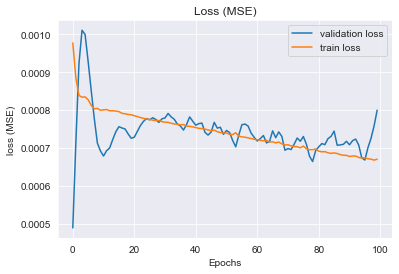

In [51]:
visualize_training_results(result1)

Our validation loss (MSE) converges at about 50 epochs.

One thing to note here is that LSTM modeling is very powerful when tuned so we will try and improve on this and see if we can do better than our ARIMA model.

Let's plot the predictions our model made against the true values.

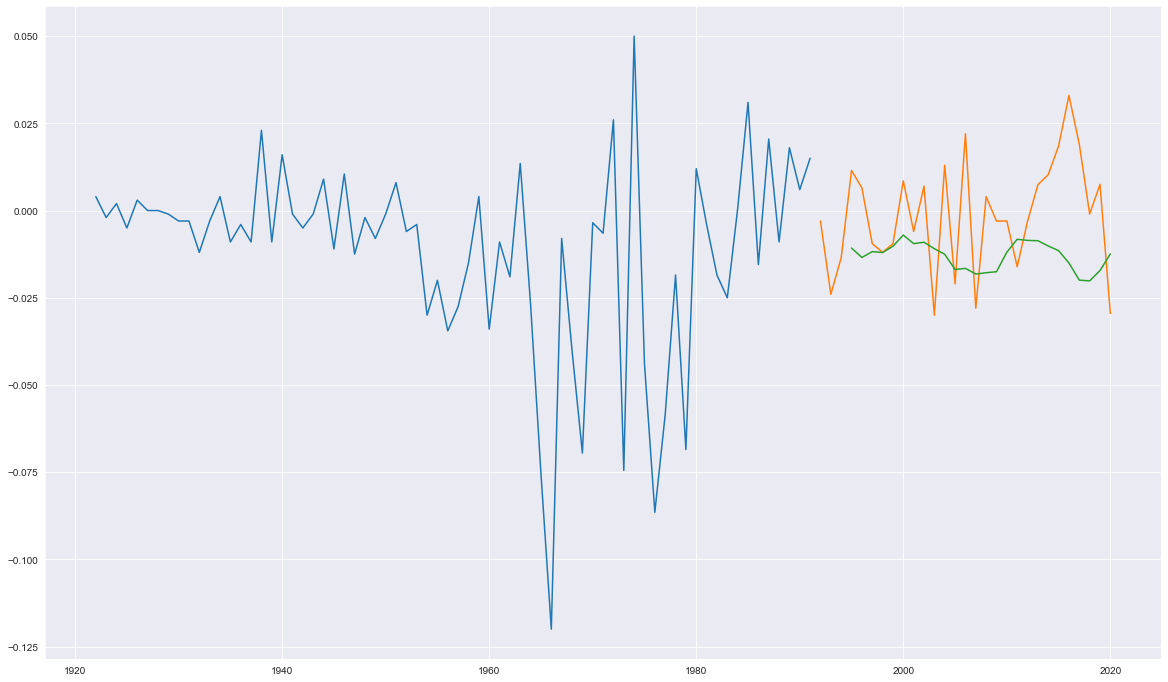

In [52]:
fig,ax=plt.subplots(figsize=(20,12))

plt.plot(train)
plt.plot(test)
plt.plot(test.index[3:], yhat) #predictions


# preds is series, need to attribute values to the datetime of test set

## Stacking LSTM Layers
Let's see if adding hidden layers will improve the RMSE of our model's predictions. Let's also lower the number of training epochs to 60, as it is likely, again, the convergence will happen before that.

The ouput sequence shape of this extra LSTM layer needs to match the input of the next, so we will set the 'return_sequences' parameter to true.

In [ ]:
model2 = Sequential()
model2.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))  
model2.add(LSTM(25, activation='relu'))
model2.add(Dense(1))
# model2.add(Dropout(0.1))  #Dropout penalizes a more-complex model. It made our RMSE much worse here
model2.compile(optimizer='adam', loss='mse')

result2 = model2.fit(X_train, y_train, epochs=60, validation_split=(0.1))

yhat2 = model2.predict(X_test)
print('\n')
rmse = np.sqrt(mean_squared_error(y_test, yhat2))
print('Baseline MSE:', mean_squared_error(y_test, yhat2))
print('Baseline RMSE:', rmse)

Now our results for each run of the model vary slightly, due to the stochastic nature of the algorithm. This considered, the extra layer seems to have improved the model.

In [ ]:
visualize_training_results(result2)

One thing noticed here, is the convergence is happening earlier.

## Bidirectional LSTM
Bidirectional modeling will learn the input sequences both forwards and backwards and then combine both learnings.

In [ ]:
model3 = Sequential()
model3.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse')

result3 = model3.fit(X_train, y_train, epochs=60, validation_split=(0.1))

yhat3 = model3.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, yhat3))
print('\n')
print('MSE:', mean_squared_error(y_test, yhat3))
print('RMSE:', rmse)

visualize_training_results(result3)

RMSE worse here. Let's refer back to the first two LSTM models.

## Stationary Data for LSTM*
Although not necessary for LSTMs, it could make the model's job easier by feeding it differenced data. Let's use the differenced acousticness values that we used for our intial ARIMA modeling.

In [ ]:
data_diff

In [ ]:
train=data_diff[:90] 
test=data_diff[90:]

# define input sequence
train_seq = list(train)
test_seq = list(test)

# choose a number of time steps
n_steps = 5      #here 3 and 2 steps received worse results

# split into samples
X_train, y_train = split_sequence(train_seq, n_steps)
X_test, y_test = split_sequence(test_seq, n_steps) 

n_features = 1

# #reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))


# print the data sequence with steps:
# for i in range(len(X_train)):
# 	print(X_train[i], y_train[i])

In [ ]:
model4 = Sequential()
model4.add(LSTM(50, activation='linear', input_shape=(n_steps, n_features)))
model4.add(Dense(1))
model4.compile(optimizer='adam', loss='mse')

result4 = model4.fit(X_train, y_train, batch_size=100, epochs=200, validation_split=(0.2))

yhat4 = model4.predict(X_test)
print('\n')
rmse = np.sqrt(mean_squared_error(y_test, yhat4))
print('Baseline MSE:', mean_squared_error(y_test, yhat4))
print('Baseline RMSE:', rmse)
print('\n')
visualize_training_results(result4)

It seems differenced data is making a difference! (No pun intended). The RMSE on average is slightly lower than our best performing LSTM model thus far. However is it not quite better than our best ARIMA model, still.

As far as model validation, our validation set is actually performing better than the training set. If it were the opposite, our model would be overfitting, however we are ok here I believe.

With activation set to 'linear' instead of 'relu', we were able to get slightly better results.

*This validation loss is also exhibiting signs of overfitness. Let's stop the epochs at 100.*

As each prediction for this model takes 5 previous steps to generate, there is a 5-step space in between our testing data and our prediction data. For this reason we will plot only the y_test values (5-step sequenced test data) against our prediction.

In [ ]:
fig,ax=plt.subplots(figsize=(20,12))

plt.plot(train)
plt.plot(test, label='Actual')
plt.plot(test.index[5:], yhat4, label='Predictions') #predictions
plt.legend(loc='best')


As this model had the best RMSE we will go with this, however the predictions are not looking exceptional here.

# Forecasting Future Values
## acousticness
We will now be using our best performing LSTM model to forecast the values for acousticness, 5 years into the future.

In [ ]:
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
data_diff.tail()

In [ ]:
data_diff.tail().values

Now we will run an if/else loop that will take our last 5 years (for 5 step predictions) to predict the next value. This new value while be appended to a list and the oldest value will be filtered out, leaving a new 5 years (steps) to predict the next year, and so on.

In [ ]:
# predict values for next 5 years
x_input = data_diff.tail().values #last 5 values of the dataset
temp_input=list(x_input)
lst_output=[]
i=0
# x_input = x_input.reshape((1, n_steps, n_features))
while(i<5):  #5 years
    
    if(len(temp_input)>5):  #5 steps
        x_input=np.array(temp_input[1:])
        print("Year {} input: {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model4.predict(x_input, verbose=0)
        print("Year {} output: {}".format(i,yhat))
        print('\n')
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model4.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    

print(lst_output)

Creating y-axis values for our 5 future dates:

In [ ]:
future_years = [2021, 2022, 2023, 2024, 2025]
future_years = pd.to_datetime(future_years, format='%Y')
future_years

# Visualizing Future Values 
## differenced acousticness

In [ ]:
fig,ax=plt.subplots(figsize=(20,12))

# plt.plot(train)
# plt.plot(test)
plt.plot(test.index[5:], yhat4, label='Predictions') #predictions
plt.plot(test.index[5:], y_test, label='Actual')
plt.plot(future_years, lst_output, label='Forecast')

plt.legend(loc='best', fontsize='x-large')

Great now we do have our forecasted values for acousticness, however this is still the differenced data and we will need to see the forecasted values in our original scale. For this, we will revert back to the original scale by getting the cumulative sum of the differenced data.

In [ ]:
lst_output

In [ ]:
yearly_df.acousticness.iloc[-1]

Now in order to rescale the differenced forecast, we will need the last value from the original dataset to add the cumulative sums to. So we are inserting that last value to the beginning of the forecasted list.

In [ ]:
lst_output.insert(0,yearly_df.acousticness.iloc[-1])

In [ ]:
lst_output

In [ ]:
rescaled_forecast = np.cumsum(lst_output)
rescaled_forecast[1:]

## Rescaled Forecast, acousticness

Now let's clean up our forecast values, by organized them into a new dataframe. We can then add the forecasts for all features into this one dataframe.

In [ ]:
forecast_df = pd.DataFrame(index=future_years)
forecast_df.index.name = 'future_years'
forecast_df

In [ ]:
forecast_df['acousticness'] = rescaled_forecast[1:]
forecast_df

In [ ]:
fig,ax=plt.subplots(figsize=(20,12))

plt.plot(yearly_df.acousticness, label='Actual')
plt.plot(forecast_df.acousticness, label='Forecast')

plt.legend(loc='best')

# Entire Model Consolidation
We will now try and consolidate our entire best model and forecasting loop into a singular function, which we can apply to the rest of the features for forecasting.

In [ ]:
def run_model(df):
    
    '''Runs an LSTM model with 5 steps, linear activation, and one dense layer
    on a date-time-indexed dataframe. 
    
    Takes a dataframe, differences it by 1-lag and splits into 90/10 train/test
    split. Then splits training and test sets into sequences required by the 
    model of 5 input steps and 1 output step. 
    
    Model is trained using 20% validation taken from the training set, and 
    tested on unseen test set. (Differenced) Predictions are then forecasted 
    5 steps into the future and "undifferenced" using np.cumsum of the original
    dataset's last value.
    
    Inputs: dataframe with a date-time index.
    
    Outputs: RMSE, loss function curve, and updated forecast dataframe with
             predicted values.
    '''
    
    #difference the column's data
    differenced_df = df.diff().dropna()
    
    #split df for train/test
    train=differenced_df[:90] 
    test=differenced_df[90:]
    
    # define input sequence
    train_seq = list(train)
    test_seq = list(test)
    n_steps = 5
    
    # split into samples
    X_train, y_train = split_sequence(train_seq, n_steps)
    X_test, y_test = split_sequence(test_seq, n_steps)
    n_features = 1
    
    #reshape from [samples, timesteps] into [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
    
    #instatiate model and add layers
    model = Sequential()
    model.add(LSTM(50, activation='linear', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    #fit model with 20% validation split *of the training data*
    result = model.fit(X_train, y_train, batch_size=100, epochs=200, 
                       validation_split=(0.2), verbose=0)
    
    #predict y values with test data
    yhat = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, yhat))
    print('RMSE:', rmse)
    visualize_training_results(result)
    print('\n')
    
    #forecast future values
    x_input = differenced_df.tail().values
    temp_input=list(x_input)
    lst_output=[]
    i=0
    
    while(i<5):  #5 years
        if(len(temp_input)>5):  #5 steps
            x_input=np.array(temp_input[1:])
            x_input = x_input.reshape((1, n_steps, n_features))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])
            temp_input=temp_input[1:]
            lst_output.append(yhat[0][0])
            i=i+1
        
        else:
            x_input = x_input.reshape((1, n_steps, n_features))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])
            lst_output.append(yhat[0][0])
            i=i+1
            
    # invert differencing of forecasts
    lst_output.insert(0, df.iloc[-1])    
    rescaled_forecast = np.cumsum(lst_output)
    rescaled_forecast = rescaled_forecast[1:]
    return rescaled_forecast

# All Features Forecasting

## danceability

In [ ]:
rescaled_forecast = run_model(yearly_df.danceability)
rescaled_forecast
forecast_df['danceability'] = rescaled_forecast
forecast_df

## duration_ms

In [ ]:
rescaled_forecast = run_model(yearly_df.duration_ms)
rescaled_forecast
forecast_df['duration_ms'] = rescaled_forecast
forecast_df

## energy

In [ ]:
rescaled_forecast = run_model(yearly_df.energy)
rescaled_forecast
forecast_df['energy'] = rescaled_forecast
forecast_df

## loudness

In [ ]:
rescaled_forecast = run_model(yearly_df.loudness)
rescaled_forecast
forecast_df['loudness'] = rescaled_forecast
forecast_df

## instrumentalness

In [ ]:
yearly_df.instrumentalness.tail(20)

In [ ]:
rescaled_forecast = run_model(yearly_df.instrumentalness)
rescaled_forecast
forecast_df['instrumentalness'] = rescaled_forecast
forecast_df

Note: Another very odd prediction. The values for the last 10 years at least were <0.001, so not sure why the model is predicting a sudden rise in 'instrumentalness'.

## liveness

In [ ]:
rescaled_forecast = run_model(yearly_df.liveness)
rescaled_forecast
forecast_df['liveness'] = rescaled_forecast
forecast_df

## speechiness

In [ ]:
rescaled_forecast = run_model(yearly_df.speechiness)
rescaled_forecast
forecast_df['speechiness'] = rescaled_forecast
forecast_df

## tempo

In [ ]:
rescaled_forecast = run_model(yearly_df.tempo)
rescaled_forecast
forecast_df['tempo'] = rescaled_forecast
forecast_df

## valence

In [ ]:
rescaled_forecast = run_model(yearly_df.valence)
rescaled_forecast
forecast_df['valence'] = rescaled_forecast
forecast_df

## popularity

In [ ]:
rescaled_forecast = run_model(yearly_df.popularity)
rescaled_forecast
forecast_df['popularity'] = rescaled_forecast
forecast_df

## key

Key is difficult as it is really a categorical feature, for which we took the mode of each year for our yearly_df dataset. This is causing our loss function for Mean Squared Error to look haywire, as the model is predicting decimal values in between the 'key' values which are only whole integers. 
This model needs some improving for sure, but as the 5-year prediction gives us a value very close to 0, we will assume the median key in 2025 will just be 0.

In [ ]:
rescaled_forecast = run_model(yearly_df.key)
rescaled_forecast
forecast_df['key'] = rescaled_forecast
forecast_df

In [ ]:
forecast_df.to_csv(r'Datasets/forecast_df.csv', index = False);

In [ ]:
forecast_df

## Visualizing all future features

Let's plot some forecast predictions against their true values.

In [ ]:
fig,ax=plt.subplots(figsize=(20,12))

#actual values
ax.plot(yearly_df.acousticness, label='Actual Acousticness')
ax.plot(yearly_df.danceability, label='Actual Danceability')
ax.plot(yearly_df.energy, label='Actual Energy')
ax.plot(yearly_df.instrumentalness, label='Actual Instrumentalness')
ax.plot(yearly_df.liveness, label='Actual Liveness')
ax.plot(yearly_df.valence, label='Actual Valence')
ax.plot(yearly_df.speechiness, label='Actual Speechiness')

#predicted values
ax.plot(forecast_df.acousticness, label='Acousticness Forecast')
ax.plot(forecast_df.danceability, label='Danceability Forecast')
ax.plot(forecast_df.energy, label='Energy Forecast')
ax.plot(forecast_df.instrumentalness, label='Instrumentalness Forecast')
ax.plot(forecast_df.liveness, label='Liveness Forecast')
ax.plot(forecast_df.valence, label='Valence Forecast')
ax.plot(forecast_df.speechiness, label='Speechiness Forecast')

# labels
plt.xlabel('Year', size=14)
plt.ylabel('Value (normalized)', size=14)
plt.legend(loc='best', fontsize='x-large', ncol=2)
plt.savefig('Images/forecasted_normalized_features.png');

Loudness forecast:

In [ ]:
fig,ax=plt.subplots(figsize=(20,12))
ax.plot(yearly_df.loudness, label='Actual loudness')
ax.plot(forecast_df.loudness, label='Actual loudness')
plt.xlabel('Year', size=14)
plt.ylabel('Value', size=14)
plt.legend(loc='best');

Tempo Forecast:

In [ ]:
fig,ax=plt.subplots(figsize=(20,12))
ax.plot(yearly_df.tempo, label='Actual tempo ')
ax.plot(forecast_df.tempo, label='Forecast')
plt.xlabel('Year', size=14)
plt.ylabel('Value', size=14)
plt.legend(loc='best');

Popularity:

In [ ]:
fig,ax=plt.subplots(figsize=(20,12))
ax.plot(yearly_df.popularity, label='Actual popularity')
ax.plot(forecast_df.popularity, label='Forecasted popularity')
plt.xlabel('Year', size=14)
plt.ylabel('Value', size=14)
plt.legend(loc='best');

After having thought for some time, I am questioning if 'popularity' should even be relevant as it is a function of the amount of streams per time, which clearly takes account a factor of the ever-growing user base of Spotify. Basically, as time goes on, there will obviously be songs that are listened to more than in the past.

# Conclusions
We have successfully forecasted each of our features. So what do they tell us? Our model predicts that by 2025, the average (median) song will possess the following characteristics:

Tempo will have increased to back around 122.2 BPM.
Loudness will have continued to rebound, and reach a median of nearly -6db. (quite loud!)
Instrumentalness in songs could possibly have made a comeback, increasing from 0. 
Speechiness (vocals/spoken words) will have plateaued.
Acousticness will be much lower again, down to 0.08.
Average Popularity will continue to grow.
Valence (positivity/happiness) will have dipped and plateaued at 0.455.
Energy will continue to rebound and hit 0.649.
Danceability will more or less plateau as well, only rising by a small fraction to 0.697. In otherwords, peak danceability is here to stay for the next 5 years.






*Extra Notes:*

After subsequent research, it is often suggested that simple time series, with less data points, do better with ARIMA modeling, while LSTM models are potentially better and more efficiently performing with very complex time series.

This considered we were able to obtain a decent RMSE for each feature with LSTM modeling, using stationarized data, for our final forecasting.

# APPENDIX


In this post-project section, I will be trying other methods to further validate my model. (as per recommendation of mock technical interviewer (Senior Data Scientist, Washington Post)). 

## Greater test value range in training/testing
One particular recommendation was to train my best model on a wider range of values in relation to the range of the data. So instead of a 0.2 validation split where the value range of the test set is also only about 10%, I will train using a wider range of 40% validation.

In [53]:
yearly_df.acousticness[50:]

year
1971-01-01    0.4365
1972-01-01    0.4625
1973-01-01    0.3880
1974-01-01    0.4380
1975-01-01    0.3940
1976-01-01    0.3075
1977-01-01    0.2490
1978-01-01    0.2305
1979-01-01    0.1620
1980-01-01    0.1740
1981-01-01    0.1700
1982-01-01    0.1515
1983-01-01    0.1265
1984-01-01    0.1270
1985-01-01    0.1580
1986-01-01    0.1425
1987-01-01    0.1630
1988-01-01    0.1540
1989-01-01    0.1720
1990-01-01    0.1780
1991-01-01    0.1930
1992-01-01    0.1900
1993-01-01    0.1660
1994-01-01    0.1525
1995-01-01    0.1640
1996-01-01    0.1705
1997-01-01    0.1610
1998-01-01    0.1490
1999-01-01    0.1395
2000-01-01    0.1480
2001-01-01    0.1420
2002-01-01    0.1490
2003-01-01    0.1190
2004-01-01    0.1320
2005-01-01    0.1110
2006-01-01    0.1330
2007-01-01    0.1050
2008-01-01    0.1090
2009-01-01    0.1060
2010-01-01    0.1030
2011-01-01    0.0869
2012-01-01    0.0838
2013-01-01    0.0912
2014-01-01    0.1015
2015-01-01    0.1200
2016-01-01    0.1530
2017-01-01    0.1720
2018-01-

In [74]:
print(yearly_df.acousticness[60])
print(yearly_df.acousticness[70])

0.17
0.193


In [75]:
yearly_df.acousticness[50] - yearly_df.acousticness[90]

0.34960000000000013

This product above, 0.349, represents the range of value out of 1, 34.9% for our validation set. 

In [78]:
data_diff

year
1922-01-01    0.0040
1923-01-01   -0.0020
1924-01-01    0.0020
1925-01-01   -0.0050
1926-01-01    0.0030
               ...  
2016-01-01    0.0330
2017-01-01    0.0190
2018-01-01   -0.0010
2019-01-01    0.0075
2020-01-01   -0.0295
Name: acousticness, Length: 99, dtype: float64

In [79]:
train=data_diff[:70] 
test=data_diff[70:]

# define input sequence
train_seq = list(train)
test_seq = list(test)

# choose a number of time steps
n_steps = 5      #here 3 and 2 steps received worse results

# split into samples
X_train, y_train = split_sequence(train_seq, n_steps)
X_test, y_test = split_sequence(test_seq, n_steps) 

n_features = 1

# #reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))



# print the data sequence with steps:
# for i in range(len(X_train)):
# 	print(X_train[i], y_train[i])

Train on 45 samples, validate on 20 samples
Epoch 1/200
45/45 [==============================] - 1s 26ms/step - loss: 6.5537e-04 - val_loss: 0.0013
Epoch 2/200
45/45 [==============================] - 0s 152us/step - loss: 5.7358e-04 - val_loss: 0.0013
Epoch 3/200
45/45 [==============================] - 0s 143us/step - loss: 5.5308e-04 - val_loss: 0.0014
Epoch 4/200
45/45 [==============================] - 0s 142us/step - loss: 5.8657e-04 - val_loss: 0.0014
Epoch 5/200
45/45 [==============================] - 0s 160us/step - loss: 6.0125e-04 - val_loss: 0.0014
Epoch 6/200
45/45 [==============================] - 0s 156us/step - loss: 5.8329e-04 - val_loss: 0.0014
Epoch 7/200
45/45 [==============================] - 0s 153us/step - loss: 5.5779e-04 - val_loss: 0.0013
Epoch 8/200
45/45 [==============================] - 0s 174us/step - loss: 5.4387e-04 - val_loss: 0.0013
Epoch 9/200
45/45 [==============================] - 0s 162us/step - loss: 5.4582e-04 - val_loss: 0.0013
Epoch 10/200

Epoch 78/200
45/45 [==============================] - 0s 175us/step - loss: 5.1585e-04 - val_loss: 0.0014
Epoch 79/200
45/45 [==============================] - 0s 165us/step - loss: 5.1576e-04 - val_loss: 0.0014
Epoch 80/200
45/45 [==============================] - 0s 157us/step - loss: 5.1568e-04 - val_loss: 0.0014
Epoch 81/200
45/45 [==============================] - 0s 146us/step - loss: 5.1562e-04 - val_loss: 0.0014
Epoch 82/200
45/45 [==============================] - 0s 159us/step - loss: 5.1556e-04 - val_loss: 0.0014
Epoch 83/200
45/45 [==============================] - 0s 158us/step - loss: 5.1549e-04 - val_loss: 0.0014
Epoch 84/200
45/45 [==============================] - 0s 169us/step - loss: 5.1542e-04 - val_loss: 0.0014
Epoch 85/200
45/45 [==============================] - 0s 148us/step - loss: 5.1535e-04 - val_loss: 0.0014
Epoch 86/200
45/45 [==============================] - 0s 148us/step - loss: 5.1528e-04 - val_loss: 0.0014
Epoch 87/200
45/45 [==========================

Epoch 155/200
45/45 [==============================] - 0s 170us/step - loss: 5.1317e-04 - val_loss: 0.0014
Epoch 156/200
45/45 [==============================] - 0s 150us/step - loss: 5.1316e-04 - val_loss: 0.0014
Epoch 157/200
45/45 [==============================] - 0s 204us/step - loss: 5.1315e-04 - val_loss: 0.0014
Epoch 158/200
45/45 [==============================] - 0s 159us/step - loss: 5.1314e-04 - val_loss: 0.0014
Epoch 159/200
45/45 [==============================] - 0s 147us/step - loss: 5.1313e-04 - val_loss: 0.0014
Epoch 160/200
45/45 [==============================] - 0s 198us/step - loss: 5.1313e-04 - val_loss: 0.0014
Epoch 161/200
45/45 [==============================] - 0s 148us/step - loss: 5.1312e-04 - val_loss: 0.0014
Epoch 162/200
45/45 [==============================] - 0s 154us/step - loss: 5.1311e-04 - val_loss: 0.0014
Epoch 163/200
45/45 [==============================] - 0s 197us/step - loss: 5.1310e-04 - val_loss: 0.0014
Epoch 164/200
45/45 [================

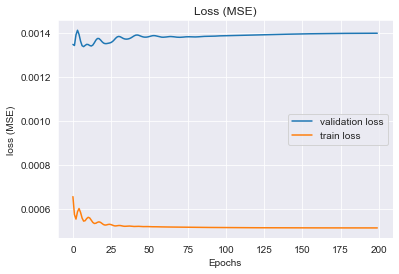

In [80]:
appmodel = Sequential()
appmodel.add(LSTM(50, activation='linear', input_shape=(n_steps, n_features)))
appmodel.add(Dense(1))
appmodel.compile(optimizer='adam', loss='mse')

appmodelresult = appmodel.fit(X_train, y_train, batch_size=100, epochs=200, validation_split=(0.3))

yhat5 = appmodel.predict(X_test)
print('\n')
rmse = np.sqrt(mean_squared_error(y_test, yhat5))
print('Baseline MSE:', mean_squared_error(y_test, yhat5))
print('Baseline RMSE:', rmse)
print('\n')
visualize_training_results(appmodelresult)

As the validation loss is higher than, and never converges with the training loss, our model is underfit. Let's try training for more time/epochs.

Train on 45 samples, validate on 20 samples
Epoch 1/500
45/45 [==============================] - 1s 19ms/step - loss: 7.2826e-04 - val_loss: 0.0014
Epoch 2/500
45/45 [==============================] - 0s 153us/step - loss: 6.0850e-04 - val_loss: 0.0014
Epoch 3/500
45/45 [==============================] - 0s 158us/step - loss: 5.9206e-04 - val_loss: 0.0014
Epoch 4/500
45/45 [==============================] - 0s 159us/step - loss: 6.2544e-04 - val_loss: 0.0014
Epoch 5/500
45/45 [==============================] - 0s 157us/step - loss: 6.3694e-04 - val_loss: 0.0014
Epoch 6/500
45/45 [==============================] - 0s 157us/step - loss: 6.1857e-04 - val_loss: 0.0014
Epoch 7/500
45/45 [==============================] - 0s 197us/step - loss: 5.9259e-04 - val_loss: 0.0013
Epoch 8/500
45/45 [==============================] - 0s 172us/step - loss: 5.7635e-04 - val_loss: 0.0013
Epoch 9/500
45/45 [==============================] - 0s 150us/step - loss: 5.7481e-04 - val_loss: 0.0013
Epoch 10/500

Epoch 78/500
45/45 [==============================] - 0s 209us/step - loss: 5.1950e-04 - val_loss: 0.0014
Epoch 79/500
45/45 [==============================] - 0s 145us/step - loss: 5.1935e-04 - val_loss: 0.0014
Epoch 80/500
45/45 [==============================] - 0s 192us/step - loss: 5.1922e-04 - val_loss: 0.0014
Epoch 81/500
45/45 [==============================] - 0s 172us/step - loss: 5.1911e-04 - val_loss: 0.0014
Epoch 82/500
45/45 [==============================] - 0s 171us/step - loss: 5.1900e-04 - val_loss: 0.0014
Epoch 83/500
45/45 [==============================] - 0s 195us/step - loss: 5.1888e-04 - val_loss: 0.0014
Epoch 84/500
45/45 [==============================] - 0s 166us/step - loss: 5.1875e-04 - val_loss: 0.0014
Epoch 85/500
45/45 [==============================] - 0s 217us/step - loss: 5.1863e-04 - val_loss: 0.0014
Epoch 86/500
45/45 [==============================] - 0s 159us/step - loss: 5.1853e-04 - val_loss: 0.0014
Epoch 87/500
45/45 [==========================

Epoch 155/500
45/45 [==============================] - 0s 196us/step - loss: 5.1396e-04 - val_loss: 0.0014
Epoch 156/500
45/45 [==============================] - 0s 165us/step - loss: 5.1393e-04 - val_loss: 0.0014
Epoch 157/500
45/45 [==============================] - 0s 168us/step - loss: 5.1390e-04 - val_loss: 0.0014
Epoch 158/500
45/45 [==============================] - 0s 148us/step - loss: 5.1388e-04 - val_loss: 0.0014
Epoch 159/500
45/45 [==============================] - 0s 156us/step - loss: 5.1385e-04 - val_loss: 0.0014
Epoch 160/500
45/45 [==============================] - 0s 160us/step - loss: 5.1382e-04 - val_loss: 0.0014
Epoch 161/500
45/45 [==============================] - 0s 143us/step - loss: 5.1379e-04 - val_loss: 0.0014
Epoch 162/500
45/45 [==============================] - 0s 153us/step - loss: 5.1377e-04 - val_loss: 0.0014
Epoch 163/500
45/45 [==============================] - 0s 154us/step - loss: 5.1374e-04 - val_loss: 0.0014
Epoch 164/500
45/45 [================

Epoch 232/500
45/45 [==============================] - 0s 168us/step - loss: 5.1297e-04 - val_loss: 0.0014
Epoch 233/500
45/45 [==============================] - 0s 155us/step - loss: 5.1296e-04 - val_loss: 0.0014
Epoch 234/500
45/45 [==============================] - 0s 162us/step - loss: 5.1296e-04 - val_loss: 0.0014
Epoch 235/500
45/45 [==============================] - 0s 149us/step - loss: 5.1295e-04 - val_loss: 0.0014
Epoch 236/500
45/45 [==============================] - 0s 163us/step - loss: 5.1295e-04 - val_loss: 0.0014
Epoch 237/500
45/45 [==============================] - 0s 157us/step - loss: 5.1295e-04 - val_loss: 0.0014
Epoch 238/500
45/45 [==============================] - 0s 166us/step - loss: 5.1294e-04 - val_loss: 0.0014
Epoch 239/500
45/45 [==============================] - 0s 152us/step - loss: 5.1294e-04 - val_loss: 0.0014
Epoch 240/500
45/45 [==============================] - 0s 159us/step - loss: 5.1293e-04 - val_loss: 0.0014
Epoch 241/500
45/45 [================

Epoch 309/500
45/45 [==============================] - 0s 182us/step - loss: 5.1272e-04 - val_loss: 0.0014
Epoch 310/500
45/45 [==============================] - 0s 143us/step - loss: 5.1272e-04 - val_loss: 0.0014
Epoch 311/500
45/45 [==============================] - 0s 167us/step - loss: 5.1272e-04 - val_loss: 0.0014
Epoch 312/500
45/45 [==============================] - 0s 134us/step - loss: 5.1271e-04 - val_loss: 0.0014
Epoch 313/500
45/45 [==============================] - 0s 163us/step - loss: 5.1271e-04 - val_loss: 0.0014
Epoch 314/500
45/45 [==============================] - 0s 186us/step - loss: 5.1271e-04 - val_loss: 0.0014
Epoch 315/500
45/45 [==============================] - 0s 230us/step - loss: 5.1270e-04 - val_loss: 0.0014
Epoch 316/500
45/45 [==============================] - 0s 146us/step - loss: 5.1270e-04 - val_loss: 0.0014
Epoch 317/500
45/45 [==============================] - 0s 159us/step - loss: 5.1270e-04 - val_loss: 0.0014
Epoch 318/500
45/45 [================

Epoch 386/500
45/45 [==============================] - 0s 147us/step - loss: 5.1242e-04 - val_loss: 0.0014
Epoch 387/500
45/45 [==============================] - 0s 187us/step - loss: 5.1241e-04 - val_loss: 0.0014
Epoch 388/500
45/45 [==============================] - 0s 172us/step - loss: 5.1241e-04 - val_loss: 0.0014
Epoch 389/500
45/45 [==============================] - 0s 153us/step - loss: 5.1240e-04 - val_loss: 0.0014
Epoch 390/500
45/45 [==============================] - 0s 163us/step - loss: 5.1240e-04 - val_loss: 0.0014
Epoch 391/500
45/45 [==============================] - 0s 162us/step - loss: 5.1239e-04 - val_loss: 0.0014
Epoch 392/500
45/45 [==============================] - 0s 155us/step - loss: 5.1239e-04 - val_loss: 0.0014
Epoch 393/500
45/45 [==============================] - 0s 155us/step - loss: 5.1238e-04 - val_loss: 0.0014
Epoch 394/500
45/45 [==============================] - 0s 161us/step - loss: 5.1238e-04 - val_loss: 0.0014
Epoch 395/500
45/45 [================

Epoch 463/500
45/45 [==============================] - 0s 158us/step - loss: 5.1193e-04 - val_loss: 0.0014
Epoch 464/500
45/45 [==============================] - 0s 162us/step - loss: 5.1192e-04 - val_loss: 0.0014
Epoch 465/500
45/45 [==============================] - 0s 177us/step - loss: 5.1191e-04 - val_loss: 0.0014
Epoch 466/500
45/45 [==============================] - 0s 166us/step - loss: 5.1190e-04 - val_loss: 0.0014
Epoch 467/500
45/45 [==============================] - 0s 172us/step - loss: 5.1189e-04 - val_loss: 0.0014
Epoch 468/500
45/45 [==============================] - 0s 166us/step - loss: 5.1188e-04 - val_loss: 0.0014
Epoch 469/500
45/45 [==============================] - 0s 151us/step - loss: 5.1188e-04 - val_loss: 0.0014
Epoch 470/500
45/45 [==============================] - 0s 162us/step - loss: 5.1187e-04 - val_loss: 0.0014
Epoch 471/500
45/45 [==============================] - 0s 172us/step - loss: 5.1186e-04 - val_loss: 0.0014
Epoch 472/500
45/45 [================

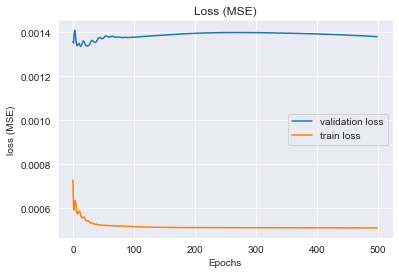

In [67]:
appmodel = Sequential()
appmodel.add(LSTM(50, activation='linear', input_shape=(n_steps, n_features)))
appmodel.add(Dense(1))
appmodel.compile(optimizer='adam', loss='mse')

appmodelresult = appmodel.fit(X_train, y_train, batch_size=100, epochs=500, validation_split=(0.3))

yhat5 = appmodel.predict(X_test)
print('\n')
rmse = np.sqrt(mean_squared_error(y_test, yhat5))
print('Baseline MSE:', mean_squared_error(y_test, yhat5))
print('Baseline RMSE:', rmse)
print('\n')
visualize_training_results(appmodelresult)

Not much difference here.

Train on 55 samples, validate on 10 samples
Epoch 1/300
55/55 [==============================] - 1s 17ms/step - loss: 0.0011 - val_loss: 3.9933e-04
Epoch 2/300
55/55 [==============================] - 0s 131us/step - loss: 9.5233e-04 - val_loss: 5.6204e-04
Epoch 3/300
55/55 [==============================] - 0s 129us/step - loss: 8.8839e-04 - val_loss: 7.6126e-04
Epoch 4/300
55/55 [==============================] - 0s 122us/step - loss: 9.0259e-04 - val_loss: 8.9856e-04
Epoch 5/300
55/55 [==============================] - 0s 123us/step - loss: 9.3729e-04 - val_loss: 9.4198e-04
Epoch 6/300
55/55 [==============================] - 0s 135us/step - loss: 9.5111e-04 - val_loss: 8.9850e-04
Epoch 7/300
55/55 [==============================] - 0s 164us/step - loss: 9.3703e-04 - val_loss: 8.0696e-04
Epoch 8/300
55/55 [==============================] - 0s 138us/step - loss: 9.1069e-04 - val_loss: 7.0242e-04
Epoch 9/300
55/55 [==============================] - 0s 138us/step - loss: 8.8789e-04 - v

Epoch 76/300
55/55 [==============================] - 0s 137us/step - loss: 8.4135e-04 - val_loss: 4.6453e-04
Epoch 77/300
55/55 [==============================] - 0s 148us/step - loss: 8.4115e-04 - val_loss: 4.6677e-04
Epoch 78/300
55/55 [==============================] - 0s 123us/step - loss: 8.4095e-04 - val_loss: 4.6929e-04
Epoch 79/300
55/55 [==============================] - 0s 160us/step - loss: 8.4076e-04 - val_loss: 4.7150e-04
Epoch 80/300
55/55 [==============================] - 0s 137us/step - loss: 8.4060e-04 - val_loss: 4.7297e-04
Epoch 81/300
55/55 [==============================] - 0s 129us/step - loss: 8.4043e-04 - val_loss: 4.7345e-04
Epoch 82/300
55/55 [==============================] - 0s 131us/step - loss: 8.4026e-04 - val_loss: 4.7291e-04
Epoch 83/300
55/55 [==============================] - 0s 131us/step - loss: 8.4008e-04 - val_loss: 4.7160e-04
Epoch 84/300
55/55 [==============================] - 0s 148us/step - loss: 8.3989e-04 - val_loss: 4.6988e-04
Epoch 85/3

55/55 [==============================] - 0s 120us/step - loss: 8.2285e-04 - val_loss: 4.7428e-04
Epoch 151/300
55/55 [==============================] - 0s 117us/step - loss: 8.2241e-04 - val_loss: 4.7458e-04
Epoch 152/300
55/55 [==============================] - 0s 123us/step - loss: 8.2196e-04 - val_loss: 4.7482e-04
Epoch 153/300
55/55 [==============================] - 0s 117us/step - loss: 8.2150e-04 - val_loss: 4.7498e-04
Epoch 154/300
55/55 [==============================] - 0s 118us/step - loss: 8.2103e-04 - val_loss: 4.7509e-04
Epoch 155/300
55/55 [==============================] - 0s 126us/step - loss: 8.2055e-04 - val_loss: 4.7521e-04
Epoch 156/300
55/55 [==============================] - 0s 140us/step - loss: 8.2007e-04 - val_loss: 4.7542e-04
Epoch 157/300
55/55 [==============================] - 0s 120us/step - loss: 8.1957e-04 - val_loss: 4.7571e-04
Epoch 158/300
55/55 [==============================] - 0s 129us/step - loss: 8.1907e-04 - val_loss: 4.7602e-04
Epoch 159/300
5

Epoch 224/300
55/55 [==============================] - 0s 152us/step - loss: 7.8479e-04 - val_loss: 4.8631e-04
Epoch 225/300
55/55 [==============================] - 0s 149us/step - loss: 7.8403e-04 - val_loss: 4.9523e-04
Epoch 226/300
55/55 [==============================] - 0s 149us/step - loss: 7.8335e-04 - val_loss: 5.1279e-04
Epoch 227/300
55/55 [==============================] - 0s 161us/step - loss: 7.8362e-04 - val_loss: 4.8802e-04
Epoch 228/300
55/55 [==============================] - 0s 257us/step - loss: 7.8314e-04 - val_loss: 4.9611e-04
Epoch 229/300
55/55 [==============================] - 0s 212us/step - loss: 7.8256e-04 - val_loss: 5.1161e-04
Epoch 230/300
55/55 [==============================] - 0s 162us/step - loss: 7.8273e-04 - val_loss: 4.9071e-04
Epoch 231/300
55/55 [==============================] - 0s 135us/step - loss: 7.8226e-04 - val_loss: 4.9570e-04
Epoch 232/300
55/55 [==============================] - 0s 148us/step - loss: 7.8185e-04 - val_loss: 5.1081e-04
E

Epoch 298/300
55/55 [==============================] - 0s 140us/step - loss: 7.7426e-04 - val_loss: 5.1641e-04
Epoch 299/300
55/55 [==============================] - 0s 121us/step - loss: 7.7431e-04 - val_loss: 4.9860e-04
Epoch 300/300
55/55 [==============================] - 0s 129us/step - loss: 7.7409e-04 - val_loss: 5.0618e-04


Baseline MSE: 0.00032083273688350333
Baseline RMSE: 0.01791180440054835




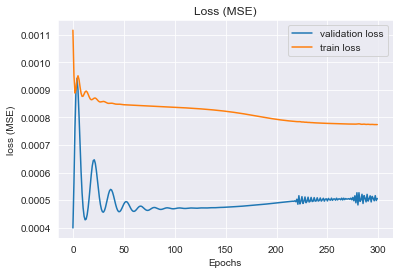

In [68]:
appmodel = Sequential()
appmodel.add(LSTM(50, activation='linear', input_shape=(n_steps, n_features)))
appmodel.add(Dense(1))
appmodel.compile(optimizer='adam', loss='mse')

appmodelresult = appmodel.fit(X_train, y_train, batch_size=100, epochs=300, validation_split=(0.15))

yhat5 = appmodel.predict(X_test)
print('\n')
rmse = np.sqrt(mean_squared_error(y_test, yhat5))
print('Baseline MSE:', mean_squared_error(y_test, yhat5))
print('Baseline RMSE:', rmse)
print('\n')
visualize_training_results(appmodelresult)

Validation loss now better than training loss, although sign of overfit when the validation loss begins to worsen at around 125 epochs. Testing again.

Train on 55 samples, validate on 10 samples
Epoch 1/125
55/55 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 3.8824e-04
Epoch 2/125
55/55 [==============================] - 0s 150us/step - loss: 9.6128e-04 - val_loss: 5.3264e-04
Epoch 3/125
55/55 [==============================] - 0s 154us/step - loss: 8.9291e-04 - val_loss: 7.1562e-04
Epoch 4/125
55/55 [==============================] - 0s 149us/step - loss: 8.9582e-04 - val_loss: 8.6795e-04
Epoch 5/125
55/55 [==============================] - 0s 170us/step - loss: 9.2942e-04 - val_loss: 9.3303e-04
Epoch 6/125
55/55 [==============================] - 0s 151us/step - loss: 9.4924e-04 - val_loss: 9.1267e-04
Epoch 7/125
55/55 [==============================] - 0s 394us/step - loss: 9.4265e-04 - val_loss: 8.3973e-04
Epoch 8/125
55/55 [==============================] - 0s 226us/step - loss: 9.2071e-04 - val_loss: 7.4352e-04
Epoch 9/125
55/55 [==============================] - 0s 131us/step - loss: 8.9695e-04 - v

Epoch 76/125
55/55 [==============================] - 0s 139us/step - loss: 8.4312e-04 - val_loss: 4.6359e-04
Epoch 77/125
55/55 [==============================] - 0s 149us/step - loss: 8.4297e-04 - val_loss: 4.6370e-04
Epoch 78/125
55/55 [==============================] - 0s 174us/step - loss: 8.4280e-04 - val_loss: 4.6491e-04
Epoch 79/125
55/55 [==============================] - 0s 173us/step - loss: 8.4262e-04 - val_loss: 4.6686e-04
Epoch 80/125
55/55 [==============================] - 0s 139us/step - loss: 8.4244e-04 - val_loss: 4.6906e-04
Epoch 81/125
55/55 [==============================] - 0s 149us/step - loss: 8.4227e-04 - val_loss: 4.7099e-04
Epoch 82/125
55/55 [==============================] - 0s 160us/step - loss: 8.4212e-04 - val_loss: 4.7224e-04
Epoch 83/125
55/55 [==============================] - 0s 131us/step - loss: 8.4197e-04 - val_loss: 4.7259e-04
Epoch 84/125
55/55 [==============================] - 0s 118us/step - loss: 8.4182e-04 - val_loss: 4.7202e-04
Epoch 85/1

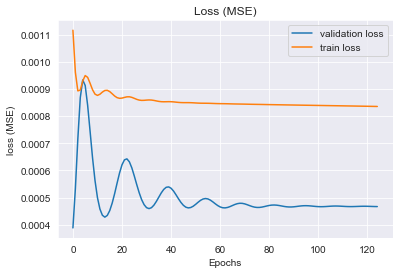

In [70]:
appmodel = Sequential()
appmodel.add(LSTM(50, activation='linear', input_shape=(n_steps, n_features)))
appmodel.add(Dense(1))
appmodel.compile(optimizer='adam', loss='mse')

appmodelresult = appmodel.fit(X_train, y_train, batch_size=100, epochs=125, validation_split=(0.15))

yhat5 = appmodel.predict(X_test)
print('\n')
rmse = np.sqrt(mean_squared_error(y_test, yhat5))
print('Baseline MSE:', mean_squared_error(y_test, yhat5))
print('Baseline RMSE:', rmse)
print('\n')
visualize_training_results(appmodelresult)

We now have decent convergence from both validation and training sets. We should still note that our testing set is possibly doing better because the testing set sequence is more simple than the training set, even with a wide range of values in comparison to the testing set (~30%). 